In [1]:
from zipfile import ZipFile
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import seaborn as sns

from data_preprocessing import PreprocessData

## Contents
1. <a href="#section_1">Import Data</a>
2. <a href="#section_2">Data Cleaning</a>
3. <a href="#section_3">Feature Engineering</a>
4. <a href="#section_4">Feature Selection</a>
5. <a href="#section_5">Models and Dataset Comparison</a>

<a id="section_1"></a>
#### Import Data

In [2]:
root_dir = "C:\\Users\\suancaibao\\Coding\\machine_learning\\datasets\\house_prices"

In [10]:
# Use Kaggle API to download data zip file.
! kaggle competitions download -c house-prices-advanced-regression-techniques


  0%|          | 0.00/199k [00:00<?, ?B/s]
100%|██████████| 199k/199k [00:00<00:00, 1.72MB/s]
100%|██████████| 199k/199k [00:00<00:00, 1.69MB/s]


In [2]:
current_dir = os.getcwd()

In [3]:
# Extract train and predict csv files.
with ZipFile(
    os.path.join(current_dir, "house-prices-advanced-regression-techniques.zip"), "r"
) as house_price_zip:
    train_dir = house_price_zip.extract("train.csv")
    predict_dir = house_price_zip.extract("test.csv")
house_price_zip.close()

train_df = pd.read_csv(train_dir)
# predict_df does not have SalePrice column.
predict_df = pd.read_csv(predict_dir)
print(f"Numbers of train_df's features is {train_df.shape[-1]}")
# predict_df does not have SalePrice column. This dataset is for submission.
print(f"Numbers of predict_df' features is {predict_df.shape[-1]}")

Numbers of train_df's features is 81
Numbers of predict_df' features is 80


<a id="section_2"></a>
#### Data Cleaning

Cleaning missing values

In [4]:
# Find columns of training and prediction datasets that contains null/missing values.
data_preprocessor = PreprocessData()
train_nullcols = data_preprocessor.find_nullvalue_cols(train_df)
print(train_nullcols)
print(len(train_nullcols))
predict_nullcols = data_preprocessor.find_nullvalue_cols(predict_df)
print("-------------------------------------------")
print(predict_nullcols)
print(len(predict_nullcols))

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
19
-------------------------------------------
['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']
33


In [6]:
# Export all columns' unique values for data preprocessing examination.
train_colsunique = data_preprocessor.cols_unique_values(train_df)
with open(os.path.join(current_dir, "unique_values.txt"), "w", encoding="UTF-8") as unique_v:
    for key, value in train_colsunique.items():
        unique_v.write("%s:%s\n" % (key, value))

In [5]:
# Replace null/missing values
train_autoreplace_col_list = ["LotFrontage", "MasVnrArea", "Electrical"]
predict_autoreplace_col_list = [
    "MSZoning", "LotFrontage", "Utilities", "Exterior1st", "Exterior2nd", "MasVnrArea", 
    "KitchenQual", "Functional", "SaleType"
]

train_manualreplace_col_list = [
    col for col in train_nullcols if col not in train_autoreplace_col_list
]
predict_manualreplace_col_list = [
    col for col in predict_nullcols if col not in predict_autoreplace_col_list
]

train_manualrepalce_value_list = [
    "No alley access", "No", "No Basement", "No Basement", "No Basement", "No Basement",
    "No Basement", "No Fireplace", "No Garage", 0, "No Garage", "No Garage", "No Garage",
    "No Pool", "No Fence", "No Features"
]

predict_manualreplace_value_list = [
    "No alley access", "No",
    "No Basement", "No Basement", "No Basement", "No Basement", 0,
    "No Basement", 0, 0, 0, 0, 0, "No Fireplace", "No Garage", 0, 
    "No Garage", 0, 0, "No Garage", "No Garage", "No Pool", "No Pool", "No Features"
]

In [6]:
train_df = data_preprocessor.replace_with_frequent_values(train_df, train_autoreplace_col_list)
predict_df = data_preprocessor.replace_with_frequent_values(predict_df, predict_autoreplace_col_list)

train_df = data_preprocessor.replace_with_ownchoice_values(
    train_df, train_manualreplace_col_list, train_manualrepalce_value_list
)
predict_df = data_preprocessor.replace_with_ownchoice_values(
    predict_df, predict_manualreplace_col_list, predict_manualreplace_value_list
)
# Double check if any columns still have null/missing values or "None" etc these values.
doublecheck_train_null = data_preprocessor.find_nullvalue_cols(train_df)
doublecheck_predict_null = data_preprocessor.find_nullvalue_cols(predict_df)
print(f"double check train_df null cols: {doublecheck_train_null}")
print("---------------------")
print(f"double check predict_df null cols: {doublecheck_predict_null}")

double check train_df null cols: []
---------------------
double check predict_df null cols: []


In [7]:
# independent_check_train_df is for analysing input data collinearity and multicollinearity
# in the feature selection.
independent_check_train_df = train_df.copy(deep=True)

In [8]:
# Export all columns' unique values again after cleaning missing values
# for inspecting if there is misplacements.
predict_colsunique = data_preprocessor.cols_unique_values(predict_df)
with open(
    os.path.join(current_dir, "unique_values_after_cleaned.txt"), "w", encoding="UTF-8"
) as unique_v:
    for key, value in predict_colsunique.items():
        unique_v.write("%s:%s\n" % (key, value))

<a id="section_3"></a>
#### Data Preprocessing

1. Convert object datatype categorical columns to numerical datatype categorical columns.
2. Split train and test dataset.
3. Removed Outliers
4. Scale continuous data columns

1. Convert object datatype categorical columns to numerical datatype categorical columns.

In [8]:
# Get a list of numerical type continuous columns.
scaling_continuous_cols = [
    "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
    "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", 
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"
]
# Get a list of object type categorical columns.
label_encoding_cols = [
    col for col in train_df.columns.tolist() if train_df[col].dtype=="object"
]

# Convert object type categorical columns to numerical type categorical columns
# for train and predict datasets.
train_df = data_preprocessor.encode_categorical_values(
    train_df, label_encoding_cols, encoding_method="ordinal"
)

predict_ds = data_preprocessor.encode_categorical_values(
    predict_df, label_encoding_cols, encoding_method="ordinal"
)

In [9]:
# Get a list of names of columns that are in object type.
train_object_cols_names = [
    col for col in train_df.columns.tolist() if train_df[col].dtype=="object"
]

train_analyze = train_df.copy()
# Convert object type columns into numerical type.
train_analyze = data_preprocessor.encode_categorical_values(
    train_analyze, train_object_cols_names, encoding_method="ordinal"
)

2. Split train and test dataset before further proprocessing data.

In [10]:
train_ds, test_ds = train_test_split(
    train_df, test_size=0.2, shuffle=True, random_state=16
)
print(f"train_ds type: {type(train_ds)}.\ntrain_ds shape: {train_ds.shape}")
print(f"test_ds type: {type(test_ds)}.\ntest_ds shape: {test_ds.shape}")

train_ds type: <class 'pandas.core.frame.DataFrame'>.
train_ds shape: (1168, 81)
test_ds type: <class 'pandas.core.frame.DataFrame'>.
test_ds shape: (292, 81)


3. Remove outliers<br>
Visualising outliers before removal

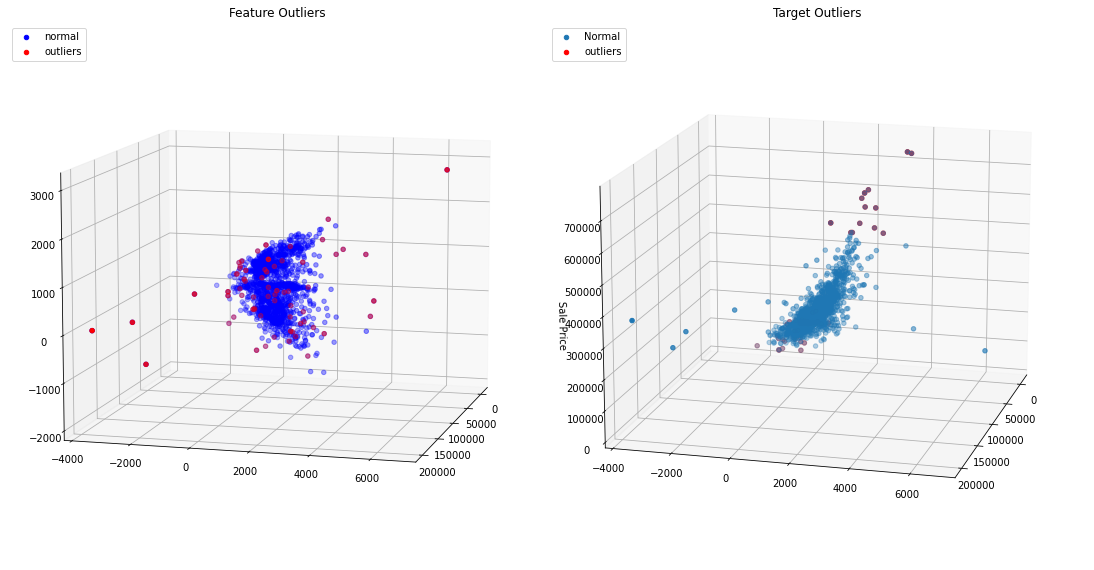

In [11]:
train_analyze = train_df.copy()
# Visualize input features outliers and target outliers separatly.
visual_x = train_analyze.drop(columns=["Id", "SalePrice"])
visual_y = train_analyze["SalePrice"].to_numpy().reshape(train_analyze.shape[0], 1)

# Use sklearn LocalOutlierFactor to find outliers.
lof_plot = LocalOutlierFactor()
# Both features_outliers_plot and target_outliers_plot are numpy array.
features_outliers_plot = lof_plot.fit_predict(visual_x)
target_outliers_plot = lof_plot.fit_predict(visual_y)
# Find outliers indexes. -1 represents outliers.
features_outliers_plot_index = np.where(features_outliers_plot==-1)
target_outliers_plot_index = np.where(target_outliers_plot==-1)

# Decompose the dataset excluding target column.
outlier_3d_pca = PCA(n_components=3)
outlier_3d_plot = outlier_3d_pca.fit_transform(visual_x)

# Create 3-d plots to view feature outliers and target outliers.
outlier_fig = plt.figure(figsize=[15, 15])

# Setting parameters for plotting feature outliers.
features_ax = outlier_fig.add_axes([0, 0, 0.5, 0.5], projection="3d")

features_x = outlier_3d_plot[features_outliers_plot_index[0], 0:1]
features_y = outlier_3d_plot[features_outliers_plot_index[0], 1:2]
features_z = outlier_3d_plot[features_outliers_plot_index[0], 2:3]

features_ax.scatter(
    outlier_3d_plot[:, 0:1], 
    outlier_3d_plot[:, 1:2],
    outlier_3d_plot[:, 2:3], color="b", label="normal"
)
features_ax.scatter(features_x, features_y, features_z, color="r", label="outliers")
features_ax.legend(loc="upper left")
features_ax.set_title("Feature Outliers")
features_ax.view_init(10, 15)

# Setting parameters for plotting target outliers.
target_ax = outlier_fig.add_axes([0.5, 0, 0.5, 0.5], projection="3d")

target_x = outlier_3d_plot[target_outliers_plot_index[0], 0:1]
target_y = outlier_3d_plot[target_outliers_plot_index[0], 1:2]
target_z = visual_y[target_outliers_plot_index[0]]

target_ax.scatter(outlier_3d_plot[:, 0:1], outlier_3d_plot[:, 1:2], visual_y, label="Normal")
target_ax.scatter(target_x, target_y, target_z, color="r", label="outliers")
target_ax.legend(loc="upper left")
target_ax.set_zlabel("Sale Price")
target_ax.set_title("Target Outliers")
target_ax.view_init(15, 15)

In [12]:
lof = LocalOutlierFactor()
# Remove features' outliers.
train_find_outliers = train_ds.drop(columns="SalePrice")
train_outlier_finder = lof.fit_predict(train_find_outliers)
train_outlier_index = np.where(train_outlier_finder==-1)
# As data splitting uses shuffle,
# the order of train_ds' indexes is not autoincrement like the train dataset before spliting.
# Thus, we need to reset train_ds index so that we can use outlier_index to remove found outliers.
print(f"Before removing outliers: train_ds shape is {train_ds.shape}")
train_ds_remove_outliers = train_ds.reset_index()
train_ds_remove_outliers.drop(index=train_outlier_index[0], axis=0, inplace=True)
train_ds_remove_outliers.drop(columns="index", inplace=True)
# Double check x_train shape after removing outliers.
print(f"After removing outliers: train_ds_remove_outliers shape is {train_ds_remove_outliers.shape}")

Before removing outliers: train_ds shape is (1168, 81)
After removing outliers: train_ds_remove_outliers shape is (1122, 81)


Generate following datasets
1. No Treatment dataset: a datasets without removing outliers.
2. Y_log_transformed dataset: log transform the target label for a dataset without removing outliers.
3. Remove Outliers dataset: a dataset with outliers removed. 

In [13]:
y_train_with_outliers = train_ds["SalePrice"].to_numpy() # Output shape is (n_examples, )
y_train_with_outliers = y_train_with_outliers.reshape(
    y_train_with_outliers.shape[0], 1
)
# log transform y_train_with_outliers.
y_train_log = np.log(y_train_with_outliers)

y_train_remove_outliers = train_ds_remove_outliers["SalePrice"].to_numpy()
y_train_remove_outliers = y_train_remove_outliers.reshape(y_train_remove_outliers.shape[0], 1)

y_test = test_ds["SalePrice"].to_numpy() # Output shape is (n_examples, )
y_test = y_test.reshape(y_test.shape[0], 1)
# Get "Id" column of predict_ds for submission dataframe.
submission_id = predict_ds["Id"].tolist()

# Drop "Id" and "SalePrice" for further input data preprocessing.
x_train_with_outliers = train_ds.drop(columns=["Id", "SalePrice"])
x_train_remove_outliers = train_ds_remove_outliers.drop(columns=["Id", "SalePrice"])
x_test = test_ds.drop(columns=["Id", "SalePrice"])
x_predict = predict_ds.drop(columns="Id")

4. Scale numerical type continuous columns.

In [14]:
x_train_with_outliers = data_preprocessor.scale_numerical_values(
    x_train_with_outliers, scaling_continuous_cols,
    scale_method="log_tranform", log_trans_repalcevalue=1
)

x_train_remove_outliers = data_preprocessor.scale_numerical_values(
    x_train_remove_outliers, scaling_continuous_cols,
    scale_method="log_tranform", log_trans_repalcevalue=1
)

x_test = data_preprocessor.scale_numerical_values(
    x_test, scaling_continuous_cols, scale_method="log_tranform", log_trans_repalcevalue=1
)

x_predict = data_preprocessor.scale_numerical_values(
    x_predict, scaling_continuous_cols, scale_method="log_tranform", log_trans_repalcevalue=1
)

In [15]:
# Make sure that number of examples in input data and its corresponding label data are the same. 
print(
    f"x_train_with_outliers {x_train_with_outliers.shape},\
 y_train_with_outliers {y_train_with_outliers.shape}"
)
print(
    f"x_train_with_outliers {x_train_with_outliers.shape},\
 y_train_log {y_train_log.shape}"
)
print(
    f"x_train_remove_outliers {x_train_remove_outliers.shape},\
 y_train_remove_outliers {y_train_remove_outliers.shape}"
)
print(f"x_test {x_test.shape}, y_test {y_test.shape}")
print(f"x_predict {x_predict.shape}")

x_train_with_outliers (1168, 79), y_train_with_outliers (1168, 1)
x_train_with_outliers (1168, 79), y_train_log (1168, 1)
x_train_remove_outliers (1122, 79), y_train_remove_outliers (1122, 1)
x_test (292, 79), y_test (292, 1)
x_predict (1459, 79)


 <a id="section_4"></a>
 ### Feature selection
 1. Collinearity analysis
 - Between continuous data columns using the Pearson correlation method.
 - Between categorical data columns using the Chi-Square test.
 - Between each categorical data column and each continuous data column using one-way Welch’s ANOVA analysis.
 2. Multicollinearity analysis using Variance Inflation Factor (VIF)<br><br>
Note that the data set used in collinearity analysis and multicollinearity analysis is train_analyze
that is a copy of train_df. The dataset has neither been split nor removed outliers nor scaled.

1. Collinearity analysis<br>
Define a list of continuous data columns and a list of categorical data columns
for pairwise features collinearity analysis.

In [16]:
continuous_cols = scaling_continuous_cols

categorical_cols = label_encoding_cols

Between continuous data columns using the Pearson correlation method.

In [17]:
corr_table = independent_check_train_df[continuous_cols].corr()

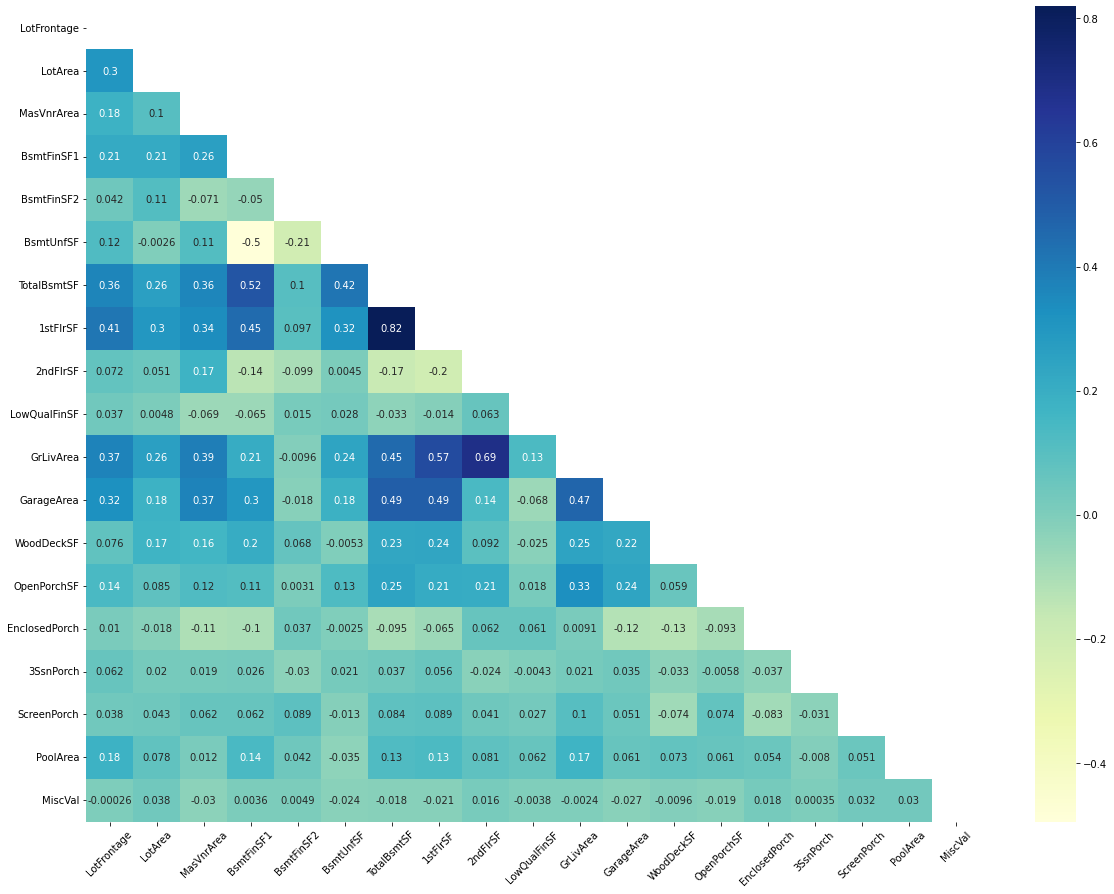

In [18]:
# Create a mask
continuous_cols_mask = np.triu(np.ones_like(independent_check_train_df[continuous_cols].corr()))

contin_col_fig, contin_col_ax = plt.subplots(1, 1, figsize=[20, 15])
continuous_cols_heatmap = sns.heatmap(
    train_analyze[continuous_cols].corr(),
    cmap="YlGnBu",
    annot=True,
    mask=continuous_cols_mask,
    ax=contin_col_ax
)
contin_cols_xlabel_rotate = plt.xticks(rotation=45)

Between categorical data columns using the Chi-Square test.

In [19]:
from scipy.stats.contingency import crosstab
from scipy.stats import chi2_contingency

# Function to create a dataframe that shows the p-value of chi-squre independent test
# between two categorical data columns.
def pairwise_chi2_test(cols_list, df):
    """
    Create a dataframe that shows the p-value of chi-squre independent test
    between two categorical data columns.

    Args:
    cols_list: a list of categorical data columns' names.
    df: a dataframe that contains the columns in cols_list.
    """
    independent_results = {}
    for col_name in cols_list:
        cate_1_name = col_name
        cate_1 = df[cate_1_name].tolist()
        p_value_list = []
        for pair_col in cols_list:
            cate_2_name = pair_col
            cate_2 = df[cate_2_name].tolist()
            # Create a contingency table.
            _, contingency_table = crosstab(cate_1, cate_2)
            _, p, _, _ = chi2_contingency(contingency_table)
            p_value_list.append(p)
        independent_results[cate_1_name] = p_value_list

    chi2_df = pd.DataFrame(independent_results, index=cols_list)

    return chi2_df

In [24]:
chi2_df = pairwise_chi2_test(categorical_cols, independent_check_train_df)

# Use heatmap to visualize the p-values.
# Create a mask
cate_col_mask = np.triu(np.ones_like(chi2_df))

cate_col_fig, cate_col_ax = plt.subplots(1, 1, figsize=[40, 40])
cate_cols_heatmap = sns.heatmap(
    chi2_df,
    cmap="YlGnBu",
    annot=True,
    mask=cate_col_mask,
    ax=cate_col_ax
)
# The heatmap graph is too big, so save it to current working directory for further analysis.
cate_cols_heatmap.get_figure().savefig(f"{current_dir}//chi2_independent_test.png")
plt.close(cate_col_fig)

Between each categorical data column and each continuous data column using one-way Welch’s ANOVA analysis.<br><br>
Use the Welch's ANOVA to obtain the p-value of variance analysis F-test to determin if
categories in each categorical data column have equality mean given the corresponding continuous data column.<br>
Before applying Welch's ANOVA analysis, data needs to meet following two assumptions:
1. Independence (We assume that sample cases are indenpendent of each other.)
2. Normality (The sample cases are normally distribution)

In [21]:
import math
from scipy.stats import shapiro
from scipy.stats import probplot
from pingouin import welch_anova

# Function to find the normality p-value of categorical data column using Shapiro-Wilk test.
def categorical_normality_test(df, categroical_colname, continuous_colname):
    """
    Create a dataframe that contains shapiro p-values of each categorical data column
    with corresponding continuous data columns.
    """
    selected_df = df[[categroical_colname, continuous_colname]]
    dropzero_df = selected_df.drop(
        selected_df.loc[selected_df[continuous_colname]==0].index
    )
    unique_groups = dropzero_df[categroical_colname].unique().tolist()
    dropzero_df.set_index(categroical_colname, inplace=True)
    result_dict = {}
    for group in unique_groups:
        x = dropzero_df.loc[group].to_numpy()
        if x.shape[0] <= 3:
            continue
        else:     
            p_value = shapiro(x).pvalue
            col_name = f"{categroical_colname}_{group}"
            result_dict[col_name] = p_value
    result_df = pd.DataFrame(result_dict, index=["shapiro_pvalue"])
    result_df = result_df.transpose()

    return result_df

# Function to create a dictionary that keys are names of the categorical data columns
# and each value of the key is a list of names of continuous data columns.
# More details please refer to the function docstring.
def bulk_normality_test(df, cate_col, contin_col, save_result=True, save_dir=None):
    """
    Create a dictionary of categorical data columns that are normality distributed with corresponding
    continuous data columns.
    The dictionary keys are names of categorical data columns.
    Each dictionary value with its corresponding key is a list of names of continuous data columns.
    The name of continuous data column is only appended in the list
    when numbers of normal distributed categories among all categories in the categorical data column
    with respect to the continuous data column pass the threshold.
    The threshold is that normal distributed categories percentage is more or equal to 80%. 

    Args:
    df: a dataframe contains columns that are in cate_col and contin_col.
    cate_col: a list of names of categorical data columns.
    contin_col: a list of names of continuous data columns.
    save_result: by default is True.
                When True, the output will be saved to the directory provided in save_dir.
    save_dir: file path.
    """
    result_dict = {}
    for categorical_col in cate_col:
        normal_contin_cols = []
        for continuous_col in contin_col:
            normality_result = categorical_normality_test(df, categorical_col, continuous_col)
            not_normal = int(normality_result.loc[normality_result["shapiro_pvalue"]<0.05].count())
            all_check = int(normality_result.shape[0])
            if all_check == 0:
                continue
            else: 
                not_normal_ratio = np.divide(not_normal, all_check)
                # If not_normal_ratio > 0.2 is True, this is equivalent to normal_ratio < 0.8,
                # so the normality test of the categorical data column using the continuous data column
                # does not pass the threshold.
                # The name of continuous data column will not be appended to the list.
                if not_normal_ratio > 0.2:
                    continue
                else:
                    normal_contin_cols.append(continuous_col)

        result_dict[categorical_col] = normal_contin_cols

    if save_result==True:
        with open(save_dir, "w", encoding="UTF-8") as file:
            for key, value in result_dict.items():
                file.write("%s:%s\n" % (key, value))
    else:
        return result_dict

# Function to create a qq plot for visualizing if the categorical data column is distributed normally
# with corresponding continuous data column.
def qq_plot(df, categorical_colname, continuous_colname, save_img=True, save_dir=None):
    """
    Create Q-Q plots to show whether each class in the categorical data columns are normally distributed.

    Args:
    df: a dataframe that contains the columns in categorical_colname and continuous_colname.
    categorical_colname: target categorical data column' names.
    continuous_colname: target continuous data column' names.
    save_dir: the folder directory that you wish to save the Q-Q plot images to.
    save_img: by default is True.
            When it is False, it will not save the image, but will show the image.
    """
    normality_df = df[[categorical_colname, continuous_colname]]
    unique_groups = normality_df[categorical_colname].unique()
    col_num = 4 # 4 images per row.
    row_num = math.ceil(len(unique_groups) / col_num)
    fig, axs = plt.subplots(row_num, col_num, figsize=[20, 20])
    fig.suptitle(
        f"{categorical_colname}_{continuous_colname}", fontsize=16, verticalalignment="center"
    )
    # For number of classes in the categorical data columns equals or is less than 4.
    if row_num == 1:
        for ax_col in range(len(unique_groups)):
            group = unique_groups[ax_col]
            ax = axs[ax_col]
            probplot(
            normality_df[normality_df[categorical_colname]==group][continuous_colname],
            dist="norm",
            plot=ax
            ) 
            ax.set_title(f"Probability Plot - category_{group}")
    # For number of classes in the categorical data columns is more than 4.
    else:
        for ax_row in range(row_num - 1):           
            for ax_col in range(col_num):
                group_idx = ax_row * col_num + ax_col
                group = unique_groups[group_idx]
                ax = axs[ax_row][ax_col]
                probplot(
                normality_df[normality_df[categorical_colname]==group][continuous_colname],
                dist="norm",
                plot=ax
                ) 
                ax.set_title(f"Probability Plot - category_{group}")
        last_ax_row = row_num - 1
        remain_groups = len(unique_groups) - last_ax_row * 4
        for last_row_col_indx in range(remain_groups):
            group_idx = last_row_col_indx + last_ax_row * 4
            group = unique_groups[group_idx]
            ax = axs[last_ax_row][last_row_col_indx]
            probplot(
                normality_df[normality_df[categorical_colname]==group][continuous_colname],
                dist="norm",
                plot=ax
            )
            ax.set_title(f"Probability Plot - category{group}")
    if save_dir == True:
        plt.savefig(f"{save_dir}//{categorical_colname}-{continuous_colname}.png")
        plt.close()
    else:
        return plt.show()
# Function for creating qq plots for all categorical data columns in the list
# and exporting the plots to current working directory.
def bulk_normality_plot(df, categorical_cols, continuous_cols, save_dir):
    for cate_col in categorical_cols:
        for contin_col in continuous_cols:
            img = qq_plot(df, cate_col, contin_col, save_dir)

    return "Done"

# Function for finding a Welch's ANOVA p-value of between a categorical data column
# and a continuous data column. 
def welchanova_test(df, categorical_colname, continuous_colname):
    """
    This function outputs a p-value of F-test in ANOVA analysis
    that indicates the independence between a pairwise categorical data column and continuous data columns.

    Args:
    df: a dataframe that contains the columns in categorical_colname and continuous_colname.
    categorical_colname: target categorical data column's name.
    continuous_colname: target continuous data column's name.
    """
    results = welch_anova(data=df, dv=continuous_colname, between=categorical_colname)
    p_value = results["p-unc"].to_numpy()[0]

    return p_value
# Function to create a dataframe that contains Welch's ANOVA p-values of each
# categorical data column in the input dictionary.
def bulk_welchanova_test(df, normal_dist_coldict, contin_list):
    """
    Create a dataframe that contains Welch's ANOVA F-test's p-values of pairwise columns.

    Args:
    df: a dataframe that contains the columns in cate_list and contin_list.
    normal_dist_coldict: a dictionary. It is an output of the function - bulk_normlity_test.
    contin_list: a list of all continuous data columns' names in the df.
    """
    normal_cate_list = list(normal_dist_coldict.keys())
    normal_cate_col_nums = len(normal_cate_list)
    contin_col_nums = len(contin_list)
    # Create a zero matrix that the dimension is
    # (numbers of continuous columns, numbers of categorical columns that pass the normality test)
    df_initialized = np.zeros((contin_col_nums, normal_cate_col_nums))
    anova_pvalue_df = pd.DataFrame(
        df_initialized,
        index=[idx for idx in range(contin_col_nums)],
        columns=normal_cate_list
    )

    for normal_cate_col, normal_contin_col_list in normal_dist_coldict.items():
        if len(normal_contin_col_list) == 0:
            continue
        else:
            normal_cate_col_indx = normal_cate_list.index(normal_cate_col)
            for normal_cotin_col in normal_contin_col_list:
                welchanova_pvalue = welchanova_test(df, normal_cate_col, normal_cotin_col)
                normal_contin_col_idx = contin_list.index(normal_cotin_col)
                # Put the p-value in the corresponding location of the dataframe.
                anova_pvalue_df.iloc[normal_contin_col_idx, normal_cate_col_indx] = welchanova_pvalue
    
    anova_pvalue_df["corresponding_contin_cols"] = contin_list
    
    return anova_pvalue_df

c:\Users\suancaibao\Coding\machine_learning\env\lib\site-packages\scipy\stats\_morestats.py:1758: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
c:\Users\suancaibao\Coding\machine_learning\env\lib\site-packages\pingouin\parametric.py:1351: RuntimeWarning: divide by zero encountered in double_scalars
  pval = f.sf(fval, ddof1, 1 / lamb)
c:\Users\suancaibao\Coding\machine_learning\env\lib\site-packages\pingouin\parametric.py:1359: RuntimeWarning: divide by zero encountered in double_scalars
  "ddof2": 1 / lamb,


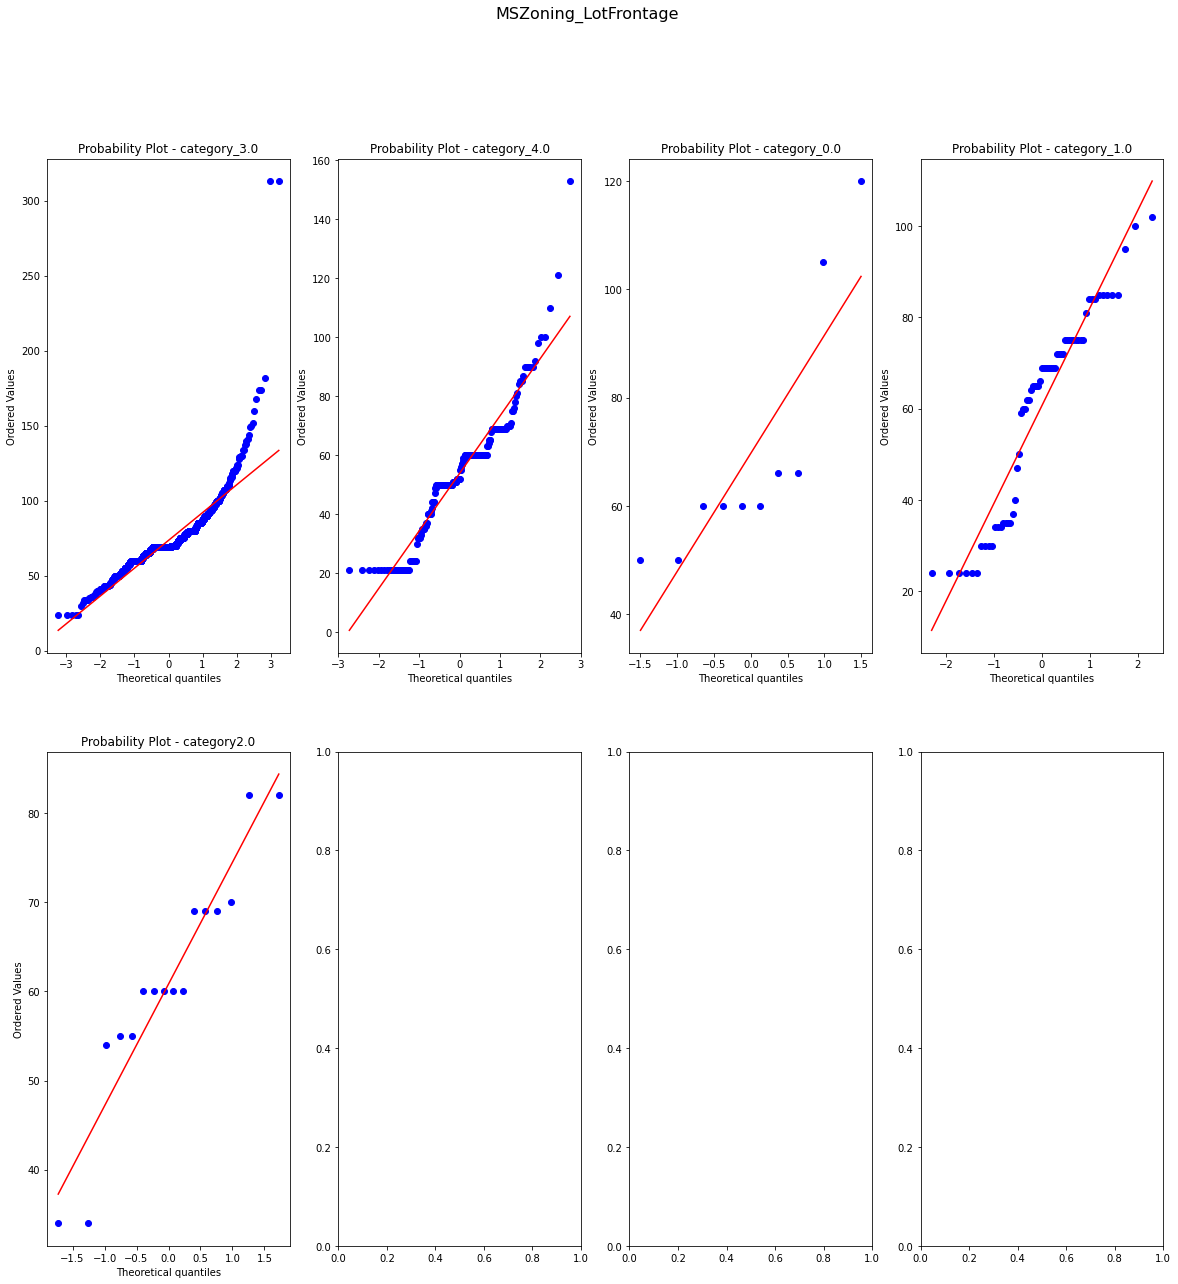

In [25]:
normal_dist_catecols = bulk_normality_test(
    independent_check_train_df, categorical_cols, continuous_cols, save_result=False
)
welchanova_df = bulk_welchanova_test(
    independent_check_train_df, normal_dist_catecols, continuous_cols
)
# Userwarning and Runtimewaring are caused by
# the categorical data column "Utilities" and the continuous data column "PoolArea".
# The majority examples have 0 pool area.

# visualise the normality of each group in cate_col.
cate_col = categorical_cols[0]
contin_col = continuous_cols[0]

qq_plot(train_analyze, cate_col, contin_col, save_img=False)

In [56]:
independent_check_train_df[["Utilities", "PoolArea"]].groupby("PoolArea").count()

,Utilities
PoolArea,
0,1453
480,1
512,1
519,1
555,1
576,1
648,1
738,1


In [ ]:
# Save all pairwise columns' collinearity test results to local directory for further analysis.
corr_table[(corr_table >= 0.5) | (corr_table <= -0.5)].count().sort_values(ascending=False).to_csv(
    f"{current_dir}//corr_analysis.csv"
)
chi2_df[(chi2_df < 0.05) & (chi2_df > 0)].count().sort_values(ascending=False).to_csv(
    f"{current_dir}//chi2_analysis.csv"
)

welchanova_df.set_index("corresponding_contin_cols", inplace=True)
welchanova_df = welchanova_df.transpose()
welchanova_df[(welchanova_df < 0.05) & (welchanova_df > 0)].count(axis=1).sort_values(ascending=False).to_csv(
    f"{current_dir}//welchanova_analysis.csv"
)

Generate dataset

In [28]:
collinear_reduced_cols = ["1stFlrSF", "BsmtFinSF1", "BsmtUnfSF",
"LotFrontage", "MSSubClass", "YearRemodAdd", "YearBuilt", "GarageYrBlt"]

collinear_x_train = x_train_remove_outliers.drop(columns=collinear_reduced_cols)
collinear_x_test = x_test.drop(columns=collinear_reduced_cols)
collinear_predict = x_predict.drop(columns=collinear_reduced_cols)
print(f"collinear_x_train shape: {collinear_x_train.shape}")
print(f"collinear_x_test shape: {collinear_x_test.shape}")
print(f"collinear_predict shape: {collinear_predict.shape}")

collinear_x_train shape: (1122, 71)
collinear_x_test shape: (292, 71)
collinear_predict shape: (1459, 71)


2. Check mutlicollinearity using variance inflation factor (VIF).<br>
VIF of 10 and above indicates a multicollinearity problem.

In [29]:
# Check variance inflation factor per feature.
train_analyze_droped = train_analyze.drop(columns=["Id", "SalePrice"])
train_vif_data = pd.DataFrame()
train_vif_data["feature"] = train_analyze_droped.columns
train_vif_data["VIF"] = [
    variance_inflation_factor(
    train_analyze_droped.values, train_i
) for train_i in range(len(train_analyze_droped.columns))
]
multicollinearity_cols = train_vif_data.loc[train_vif_data["VIF"]>=10]["feature"].tolist()
print(multicollinearity_cols)
print(len(multicollinearity_cols))

c:\Users\suancaibao\Coding\machine_learning\env\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


['MSSubClass', 'LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'YrSold', 'MSZoning', 'Street', 'Alley', 'LandContour', 'Condition2', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
48


Generate dataset

In [30]:
vif_reduced_cols = multicollinearity_cols

vif_x_train = x_train_remove_outliers.drop(columns=vif_reduced_cols)
vif_x_test = x_test.drop(columns=vif_reduced_cols)
vif_predict = x_predict.drop(columns=vif_reduced_cols)
print(f"vif_x_train shape: {vif_x_train.shape}")
print(f"vif_x_test shape: {vif_x_test.shape}")
print(f"vif_predict shape: {vif_predict.shape}")

vif_x_train shape: (1122, 31)
vif_x_test shape: (292, 31)
vif_predict shape: (1459, 31)


<a id="section_5"></a>
#### Models and Dataset Comparison
1. Linear Regression
 - Ordinal least linear regression
 - Linear regression with L1 regularization (Lasso)
 - Linear regression with L2 regularization (Ridge)
2. Kneighbor Regression
3. Epsilon-Support Vector Regression (SVR)
4. ElasticNet Regression
5. Random Forest Regression
6. Gradient Boosting Regression
7. Extreme Gradient Boosting Regression (XGBoost)
8. Stacked Generalisation Regression

In [28]:
from prediction_models import RegressionModels

In [29]:
def linear_models_comparison(
    datasets_compare_list, datasets_names, log_transform_boolen_list
):
    """
    Create a dataframe
    that shows rmse score of all datasets using different preprocessing methods.
    Args:
    datasets_compare_list: a list of datasets using different proprocessing methods.
    datasets_names: a list of data preprocessing methods' name.
                e.g. ["collinearity features reduction", "multicollinearity features reduction"]
    log_transform_boolen_list: a list of boolen indicating
                if the y target labels are log tranformed.
    """
    compare_dict = {}
    for dataset_idx, dataset_name in enumerate(datasets_names):
        dataset = datasets_compare_list[dataset_idx]
        log_transform = log_transform_boolen_list[dataset_idx]
        rmse_results = RegressionModels().linear_regression(dataset, log_tranform_y=log_transform)
        compare_dict[dataset_name] = rmse_results
    df_index = ["ord_linear_rmse", "lasso_linear_rmse", "ridge_linear_rmse"]
    compare_df = pd.DataFrame(compare_dict, index=df_index)
    compare_df = compare_df.transpose()
    return compare_df

def models_datasets_comparison(
    comparison_datasets_list, datasets_names, log_transform_boolen_list,
    model_name=None, svr_parameters=None, randomforest_parameters=None,
    gradientboosting_parameters=None, xgboosting_parameters=None
):
    """
    Create a dataframe that shows rmse of all datasets using different preprocessing methods.
    Args:
    datasets_compare_list: a list of datasets using different proprocessing methods.
    datasets_names: a list of data preprocessing methods' name.
                e.g. ["collinearity features reduction", "multicollinearity features reduction"]
    model_name: your choice of model's name.
            All choices: "knr", "svr", "elasticnet", "random forest",
                        "gridsearch gradientboosting", "gridsearch xgboosting",
                        "stacked generalization". 
    gradientboosting_parameters: a dictionary of tuning gradient boosting hyperparameters.
                e.g. {"learning_rate": [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]}
                All datasets use the same parameters for tuning.
    xgboosting_parameters: a dictionary of tuning xgboosting hyperparameters.
                e.g. {"eta": [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]}
                All datasets use the same parameters for tuning.
    log_transform_boolen_list: a list of boolen indicating
                if the y target labels are log tranformed.
    """
    compare_dict = {}
    for dataset_idx, dataset_name in enumerate(datasets_names):
        dataset = comparison_datasets_list[dataset_idx]
        log_transform = log_transform_boolen_list[dataset_idx]
        if model_name == "knr":
            rmse = RegressionModels().knn_regression(dataset, log_transform_y=log_transform)
        elif model_name == "svr":
            rmse = RegressionModels().gridsearch_svm_regression(
                dataset, svr_parameters=svr_parameters, log_transform_y=log_transform
            )
        elif model_name == "elasticnet":
            rmse = RegressionModels().elasticnet_regression(dataset, log_transform_y=log_transform)
        elif model_name == "random forest":
            rmse = RegressionModels().gridsearch_random_forest_regression(
                dataset,
                randomforest_parameters=randomforest_parameters,
                log_transform_y=log_transform
            )
        elif model_name == "gridsearch gradientboosting":
            rmse = RegressionModels().gridsearch_gradientbosting_regression(
                dataset,
                gradientboosting_parameters=gradientboosting_parameters,
                log_transform_y=log_transform
            )
        elif model_name == "gridsearch xgboosting":
            rmse = RegressionModels().gridsearch_xgboosting_regression(
                dataset,
                xgboosting_parameters=xgboosting_parameters,
                log_transform_y=log_transform
            )
        elif model_name == "stacked generalization":
            rmse = RegressionModels().stacking_regression(
                dataset,
                log_transform_y=log_transform
            )
        compare_dict[dataset_name] = rmse
    compare_df = pd.DataFrame(compare_dict, index=["rmse"])
    compare_df = compare_df.transpose()
    return compare_df

In [30]:
datasets = [
    [x_train_with_outliers, x_test, x_predict, y_train_with_outliers, y_test],
    [x_train_with_outliers, x_test, x_predict, y_train_log, y_test],
    [x_train_remove_outliers, x_test, x_predict, y_train_remove_outliers, y_test],
    [collinear_x_train, collinear_x_test, collinear_predict, y_train_remove_outliers, y_test],
    [vif_x_train, vif_x_test, vif_predict, y_train_remove_outliers, y_test]
]
datasets_names = [
    "No Treatment",
    "y_log_transformed",
    "Removed Outliers",
    "Collinearity Features Reduction with Outliers Removed",
    "Multicollinearity Features Reduction with Outliers Removed"
]
np.random.seed = 27 # For SVR C parameter reproducibility.
svr_parameters = {
    "epsilon": [0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.8],
    "C": np.random.uniform(1, 10, 10).tolist()
}
randomforest_parameters = {
    "bootstrap": [True, False],
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 4, 8, 16]
}
gradboosting_parameters = {
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.3, 0.5],
    "subsample": [0.3, 0.5, 0.7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [2, 4, 8, 16]
}
xgboosting_parameters = {
    "eta": [0.01, 0.03, 0.05, 0.1, 0.3, 0.5],
    "max_leaves": [0, 2, 4, 8, 16],
    "max_depth": [3, 6, 8, 10],
    "tree_method": ["auto", "hist"],
    "subsample": [0.3, 0.5, 0.7]
}
log_transform_boolen = [False, True, False, False, False]

In [31]:
linear_models_comparison(datasets, datasets_names, log_transform_boolen)

,ord_linear_rmse,lasso_linear_rmse,ridge_linear_rmse
No Treatment,0.191845,0.191625,0.190440
y_log_transformed,0.244162,0.334447,0.242471
Removed Outliers,0.203445,0.200459,0.190880
Collinearity Features Reduction with Outliers Removed,0.203936,0.201231,0.192271
Multicollinearity Features Reduction with Outliers Removed,0.287652,0.287637,0.287225


In [32]:
models_datasets_comparison(datasets, datasets_names, log_transform_boolen, "knr")

,rmse
No Treatment,0.249234
y_log_transformed,0.249256
Removed Outliers,0.242347
Collinearity Features Reduction with Outliers Removed,0.241218
Multicollinearity Features Reduction with Outliers Removed,0.372794


In [34]:
models_datasets_comparison(
    datasets, datasets_names, log_transform_boolen,
    "svr", svr_parameters   
)

,rmse
No Treatment,0.433536
y_log_transformed,0.218436
Removed Outliers,0.434083
Collinearity Features Reduction with Outliers Removed,0.434041
Multicollinearity Features Reduction with Outliers Removed,0.434120


In [33]:
models_datasets_comparison(
    datasets, datasets_names, log_transform_boolen,
    "elasticnet"   
)

c:\Users\suancaibao\Coding\machine_learning\env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.373e+11, tolerance: 7.125e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\suancaibao\Coding\machine_learning\env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.019e+11, tolerance: 6.427e+08
  model = cd_fast.enet_coordinate_descent(


,rmse
No Treatment,0.195552
y_log_transformed,0.292961
Removed Outliers,0.196570
Collinearity Features Reduction with Outliers Removed,0.203074
Multicollinearity Features Reduction with Outliers Removed,0.293634


In [36]:
models_datasets_comparison(
    datasets, datasets_names, log_transform_boolen,
    "random forest", randomforest_parameters=randomforest_parameters
)

,rmse
No Treatment,0.177336
y_log_transformed,0.168427
Removed Outliers,0.179283
Collinearity Features Reduction with Outliers Removed,0.183557
Multicollinearity Features Reduction with Outliers Removed,0.230849


In [37]:
models_datasets_comparison(
    datasets, datasets_names, log_transform_boolen,
    "gridsearch gradientboosting", gradientboosting_parameters=gradboosting_parameters
)

,rmse
No Treatment,0.170060
y_log_transformed,0.162675
Removed Outliers,0.170431
Collinearity Features Reduction with Outliers Removed,0.174693
Multicollinearity Features Reduction with Outliers Removed,0.236994


In [35]:
models_datasets_comparison(
    datasets, datasets_names, log_transform_boolen,
    "gridsearch xgboosting", xgboosting_parameters=xgboosting_parameters
)

,rmse
No Treatment,0.167031
y_log_transformed,0.150919
Removed Outliers,0.169972
Collinearity Features Reduction with Outliers Removed,0.169253
Multicollinearity Features Reduction with Outliers Removed,0.234478


In [38]:
models_datasets_comparison(
    datasets, datasets_names, log_transform_boolen,
    "stacked generalization"
)

,rmse
No Treatment,0.159235
y_log_transformed,0.158582
Removed Outliers,0.156106
Collinearity Features Reduction with Outliers Removed,0.167646
Multicollinearity Features Reduction with Outliers Removed,0.228324


In [24]:
best_dataset = [x_train_with_outliers, x_test, x_predict, y_train_log, y_test]
rmse, pred, best_param = RegressionModels().gridsearch_xgboosting_regression(
    best_dataset, xgboosting_parameters, True, True
)
submission_dict = {"Id": submission_id, "SalePrice": pred}
submission_df = pd.DataFrame(submission_dict)
print(rmse)

0.1509185064992679


In [24]:
submission_df.to_csv(f"{root_dir}//submissions//submissions_xgboosting1.csv", index=False)